In [1]:
import os
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# === Constantes ===
BASE_DIR  = '/kaggle/input/datanasa/visualization_outputUp'
RAINF_DIR = os.path.join(BASE_DIR, 'Rainf')
SOIL_DIR  = os.path.join(BASE_DIR, 'SoilM_0_10cm')
QSB_DIR   = os.path.join(BASE_DIR, 'Qsb')
QS_DIR    = os.path.join(BASE_DIR, 'Qs')

T = 6  # nombre de jours d'entrée
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
EXTENT = (-125, -70, 25, 50)
TARGET_SIZE = (256, 448)  # taille plus petite pour éviter OOM, divisible par 4

# === Dataset personnalisé ===
class RunoffDataset(Dataset):
    def __init__(self, rainf_dir, soil_dir, qsb_dir, qs_dir, T=6):
        self.rainf_paths = sorted(os.listdir(rainf_dir))
        self.soil_paths  = sorted(os.listdir(soil_dir))
        self.qsb_paths   = sorted(os.listdir(qsb_dir))
        self.qs_paths    = sorted(os.listdir(qs_dir))
        self.rainf_dir = rainf_dir
        self.soil_dir = soil_dir
        self.qsb_dir = qsb_dir
        self.qs_dir = qs_dir
        self.T = T

    def load_resized_gray(self, path):
        img = Image.open(path).convert("L").resize(TARGET_SIZE[::-1], Image.BILINEAR)
        return np.array(img) / 255.0

    def __len__(self):
        return len(self.qs_paths) - self.T

    def __getitem__(self, idx):
        images = []
        for t in range(idx, idx + self.T):
            rain = self.load_resized_gray(os.path.join(self.rainf_dir, self.rainf_paths[t]))
            soil = self.load_resized_gray(os.path.join(self.soil_dir, self.soil_paths[t]))
            qsb  = self.load_resized_gray(os.path.join(self.qsb_dir, self.qsb_paths[t]))

            frame = np.stack([rain, soil, qsb], axis=0)  # (C, H, W)
            images.append(frame)

        X = np.stack(images, axis=0)  # (T, C, H, W)
        X = torch.tensor(X, dtype=torch.float32)

        qs = self.load_resized_gray(os.path.join(self.qs_dir, self.qs_paths[idx + self.T])) * 2.0
        Y = torch.tensor(qs, dtype=torch.float32).unsqueeze(0)  # (1, H, W)

        return X, Y


In [2]:
# === Modèle 3D U-Net (PyTorch) ===
class UNet3D(nn.Module):
    def __init__(self, in_channels=3):
        super().__init__()

        def CBR(in_ch, out_ch):
            return nn.Sequential(
                nn.Conv3d(in_ch, out_ch, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv3d(out_ch, out_ch, kernel_size=3, padding=1),
                nn.ReLU(inplace=True)
            )

        self.enc1 = CBR(in_channels, 16)
        self.pool1 = nn.MaxPool3d((1, 2, 2))
        self.enc2 = CBR(16, 32)
        self.pool2 = nn.MaxPool3d((1, 2, 2))

        self.bottleneck = CBR(32, 64)

        self.up1 = nn.Upsample(scale_factor=(1, 2, 2), mode='trilinear', align_corners=False)
        self.dec1 = CBR(64 + 32, 32)
        self.up2 = nn.Upsample(scale_factor=(1, 2, 2), mode='trilinear', align_corners=False)
        self.dec2 = CBR(32 + 16, 16)

        self.out_conv = nn.Conv3d(16, 1, kernel_size=1)

    def forward(self, x):
        x = x.permute(0, 2, 1, 3, 4)  # (B, T, C, H, W) -> (B, C, T, H, W)
        e1 = self.enc1(x)
        p1 = self.pool1(e1)
        e2 = self.enc2(p1)
        p2 = self.pool2(e2)
        b = self.bottleneck(p2)

        u1 = self.up1(b)
        u1 = torch.cat([u1, e2], dim=1)
        d1 = self.dec1(u1)
        u2 = self.up2(d1)
        u2 = torch.cat([u2, e1], dim=1)
        d2 = self.dec2(u2)

        out = self.out_conv(d2)
        out = out[:, :, -1]  # dernière frame temporelle
        return out

In [3]:
# === Split dataset ===
ds = RunoffDataset(RAINF_DIR, SOIL_DIR, QSB_DIR, QS_DIR)
train_size = int(0.8 * len(ds))
val_size = len(ds) - train_size
train_ds, val_ds = random_split(ds, [train_size, val_size])
train_dl = DataLoader(train_ds, batch_size=2, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=2)

Epoch 1, Train Loss: 1.0779, Val Loss: 0.0560
Epoch 2, Train Loss: 0.0527, Val Loss: 0.0481
Epoch 3, Train Loss: 0.0425, Val Loss: 0.0371
Epoch 4, Train Loss: 0.0342, Val Loss: 0.0268
Epoch 5, Train Loss: 0.0219, Val Loss: 0.0190
Epoch 6, Train Loss: 0.0172, Val Loss: 0.0154
Epoch 7, Train Loss: 0.0149, Val Loss: 0.0137
Epoch 8, Train Loss: 0.0135, Val Loss: 0.0128
Epoch 9, Train Loss: 0.0129, Val Loss: 0.0123
Epoch 10, Train Loss: 0.0125, Val Loss: 0.0117


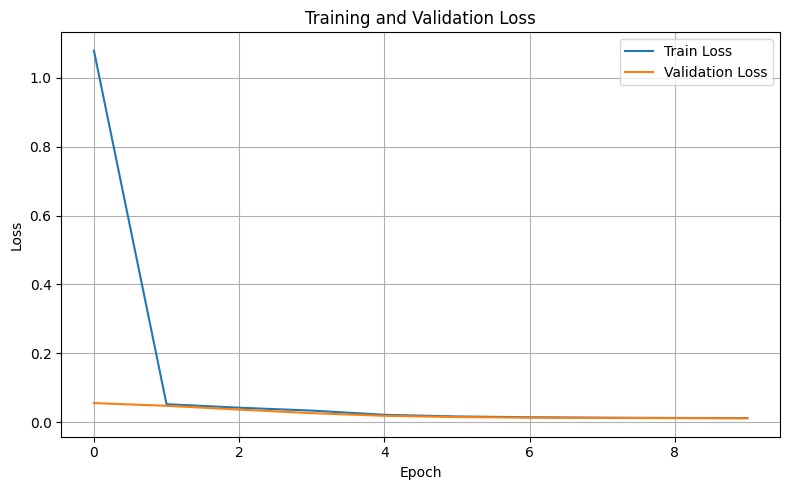

In [4]:
# === Entraînement avec suivi des pertes ===
model = UNet3D().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

train_losses, val_losses = [], []

for epoch in range(10):
    model.train()
    train_epoch_losses = []
    for X, Y in train_dl:
        X, Y = X.to(DEVICE), Y.to(DEVICE)
        optimizer.zero_grad()
        out = model(X)
        loss = criterion(out, Y)
        loss.backward()
        optimizer.step()
        train_epoch_losses.append(loss.item())
    train_loss = np.mean(train_epoch_losses)
    train_losses.append(train_loss)

    model.eval()
    val_epoch_losses = []
    with torch.no_grad():
        for X, Y in val_dl:
            X, Y = X.to(DEVICE), Y.to(DEVICE)
            out = model(X)
            loss = criterion(out, Y)
            val_epoch_losses.append(loss.item())
    val_loss = np.mean(val_epoch_losses)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

# === Courbe des pertes ===
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


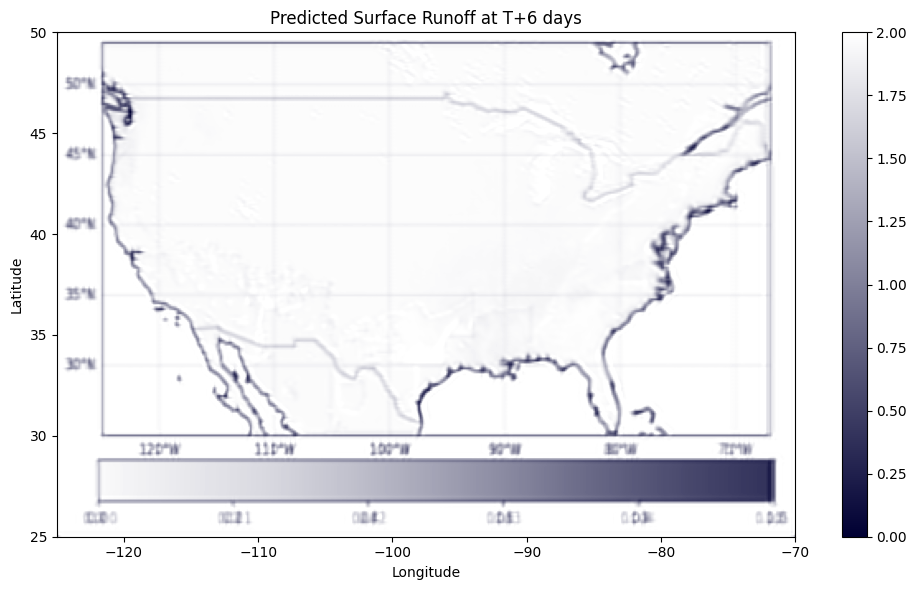

In [5]:
# === Prédiction + Affichage ===
model.eval()
with torch.no_grad():
    X0, _ = ds[-1]
    X0 = X0.unsqueeze(0).to(DEVICE)
    pred = model(X0).cpu().squeeze().numpy()

qs_map = np.flipud(pred)

colors = ['#000033', '#ffffff'] 
dark_blue_cmap = LinearSegmentedColormap.from_list('dark_blue', colors)

plt.figure(figsize=(10, 6))
plt.imshow(qs_map, origin='lower', extent=EXTENT, vmin=0, vmax=2, cmap=dark_blue_cmap, aspect='auto')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Predicted Surface Runoff at T+6 days')
plt.colorbar()
plt.tight_layout()
plt.show()
